In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS, FREQUENCY_COLOR_MAPPINGS
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt

from cli import get_file_paths

In [4]:
FREQ_GROUPS = {
                'Carp' : {'': [0, 96000],
                          'LF1': [13000, 50000],
                          'HF1': [34000, 74000],
                          'HF2': [42000, 96000]},

                'Foliage' : {'': [0, 96000],
                          'LF1': [13000, 50000],
                          'HF1': [34000, 74000],
                          'HF2': [42000, 96000]},

                'Telephone' : {'': [0, 96000],
                          'LF1': [13000, 50000],
                          'HF1': [30000, 78000],
                          'HF2': [41000, 102000]},

                'Central' : {'': [0, 96000],
                          'LF1': [13000, 50000],
                          'HF1': [34000, 74000],
                          'HF2': [42000, 96000]}
                }

In [23]:
MOD_FREQ_GROUPS = {
                'Carp' : {'': [0, 96000],
                          'LF1': [13000, 40000],
                          'HF1': [33000, 96000]},

                'Foliage' : {'': [0, 96000],
                          'LF1': [13000, 45000],
                          'HF1': [35000, 96000]},

                'Telephone' : {'': [0, 96000],
                          'LF1': [15000, 49000],
                          'HF1': [36000, 96000]},

                'Central' : {'': [0, 96000],
                          'LF1': [13000, 42000],
                          'HF1': [34000, 96000]}
                }

In [6]:
def assemble_initial_location_summary(data_params, file_paths, save=True):
    """
    Puts together all bd2 outputs in data/raw and converts detection start_times to datetime objects.
    Returns and saves a summary of bd2-detected bat calls within a desired frequency band.
    """

    location_df = dd.read_csv(f'{file_paths["raw_SITE_folder"]}/*.csv', dtype=str).compute()
    location_df['low_freq'] = location_df['low_freq'].astype('float')
    location_df['high_freq'] = location_df['high_freq'].astype('float')
    file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
    anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S')

    location_df.insert(0, 'call_end_time', anchor_end_times)
    location_df.insert(0, 'call_start_time', anchor_start_times)
    location_df.insert(0, 'ref_time', anchor_start_times)
    location_df.insert(0, 'freq_group', '')

    location_df = classify_freq_groups_in_df(location_df, data_params)

    if data_params['type_tag'] != '':
        location_df = location_df.loc[location_df['freq_group']==data_params['type_tag']]

    if save:
        location_df.to_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv')

    return location_df


def assemble_single_bd2_output(path_to_bd2_output, data_params):
    """
    Adds columns to bd2 output for a single file to be of the same format as the output
    of the assemble_initial_location_summary() method.
    """

    location_df = pd.read_csv(path_to_bd2_output)
    file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)

    anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S') 

    location_df.insert(0, 'call_end_time', anchor_end_times)
    location_df.insert(0, 'call_start_time', anchor_start_times)
    location_df.insert(0, 'ref_time', anchor_start_times)
    location_df.insert(0, 'freq_group', '')

    location_df = classify_freq_groups_in_df(location_df, data_params)
    
    return location_df


def classify_freq_groups_in_df(location_df, data_params):
    groups = MOD_FREQ_GROUPS[data_params['site_tag']]

    for group_name in groups.keys():
        if group_name != '':
            group = groups[group_name]
            call_group_bool = (location_df['low_freq']>=group[0])&(location_df['high_freq']<=group[1])
            location_df.loc[call_group_bool, 'freq_group'] = group_name

    return location_df

In [7]:
def plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed bouts and bout duurations.
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.title(f"BCI-derived bouts using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    legend_patches = []
    for group_bci in bout_params.keys():
        if group_bci!='site_key':
            bci_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_bci.split('_')[0]], 
                                      edgecolor='k', label=f'BCI = {round(bout_params[group_bci], 2)}ms')
            legend_patches.append(bci_patch)
        
    ax = plt.gca()
    for i, row in plot_bouts.iterrows():
        plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+2000)/(fs/2), 3/4), 
                            s=f"{round(row['bout_duration_in_secs'], 2)}s", color='pink', fontsize=14)
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)), loc='upper right')

    plt.tight_layout()
    plt.show()

In [8]:
site_key = 'Central'
freq_key = 'HF2'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


In [9]:
filepath_key = EXAMPLE_FILES_from_LOCATIONS[bout_params['site_key']][5]
filename = filepath_key.split('/')[-1]

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

data_params = dict()
data_params['site_tag'] = bout_params['site_key']
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 4096
spec_features['cmap'] = 'jet'

In [10]:
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt.get_bout_params_from_location(assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

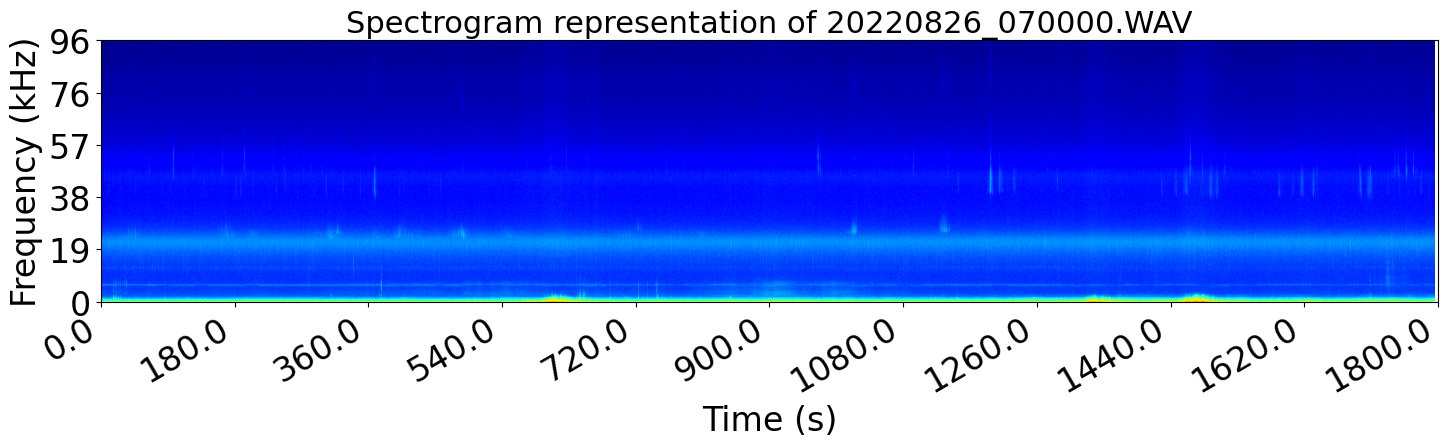

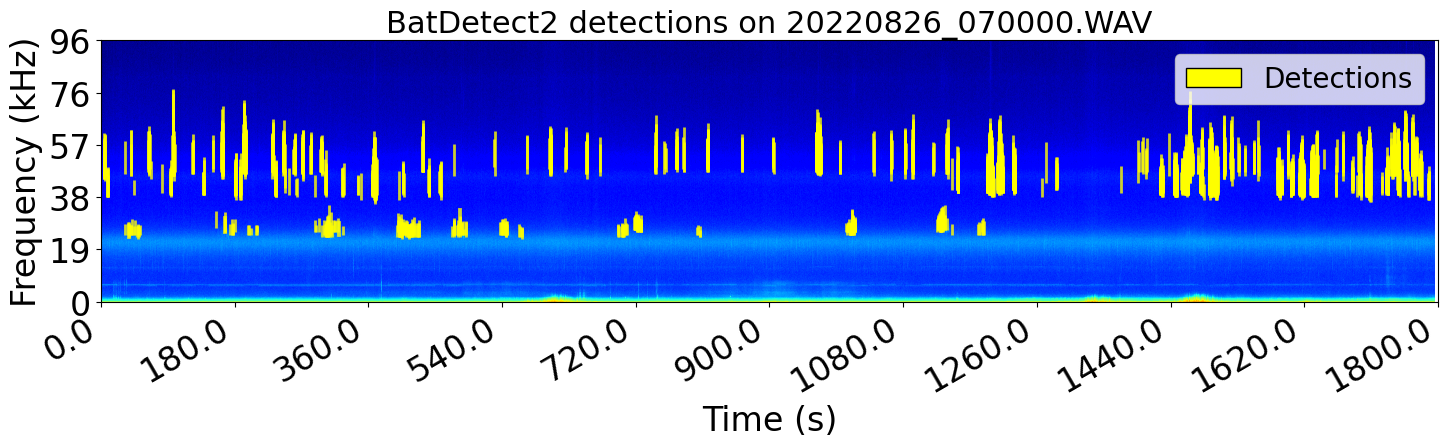

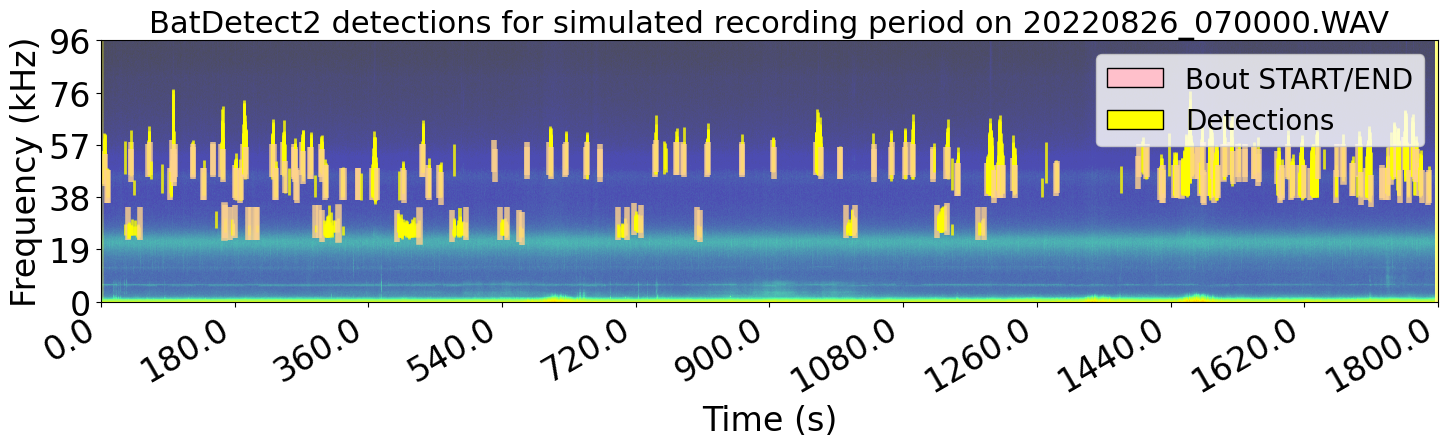

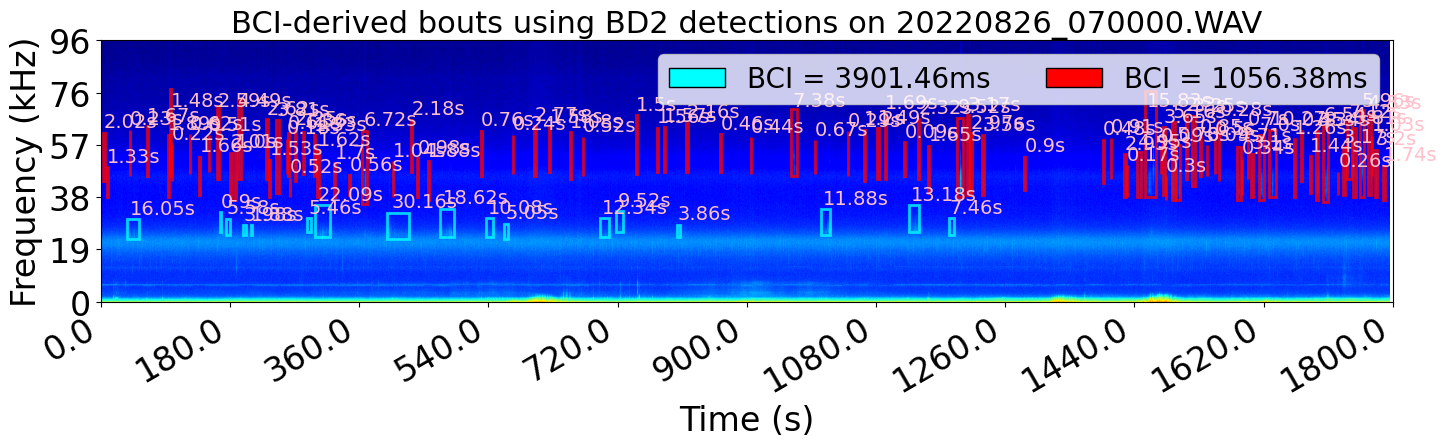

In [11]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

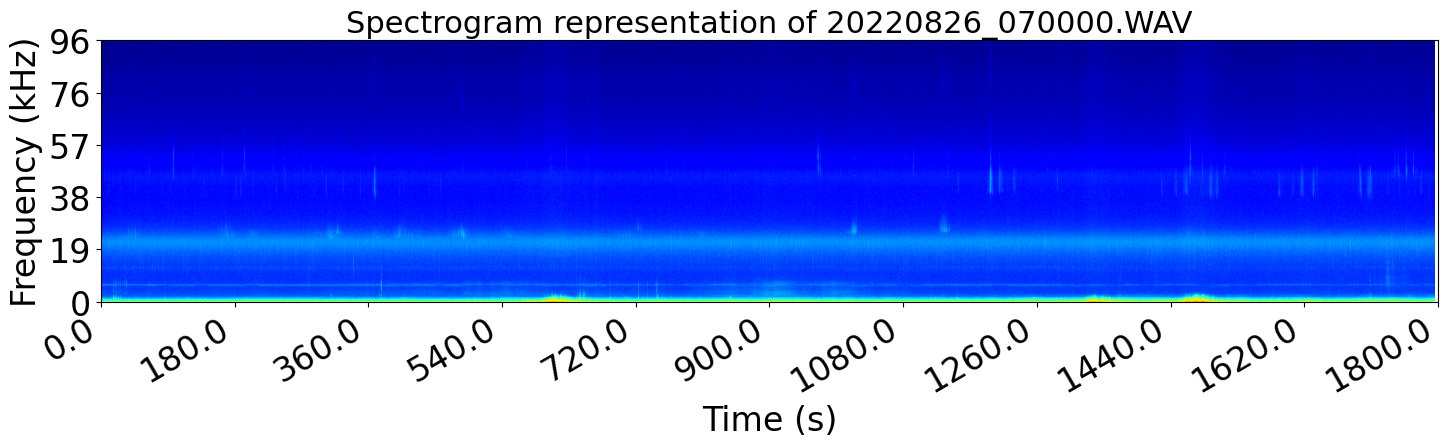

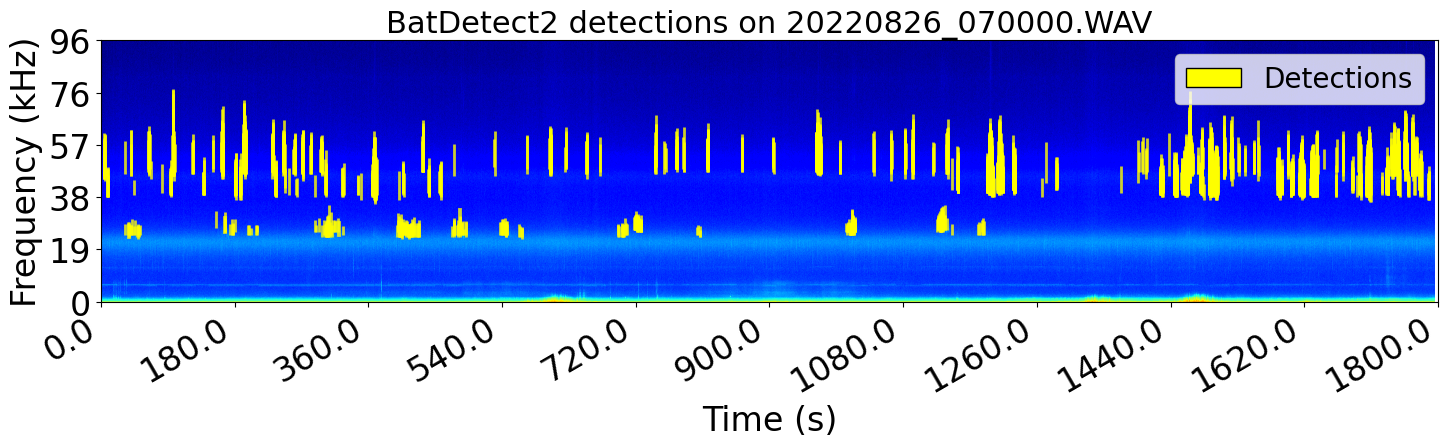

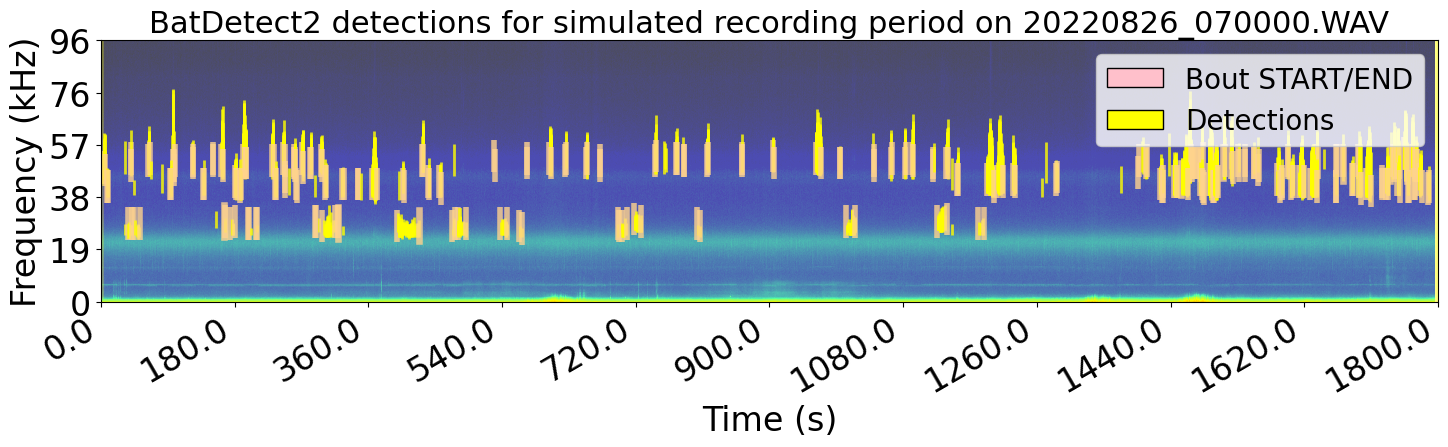

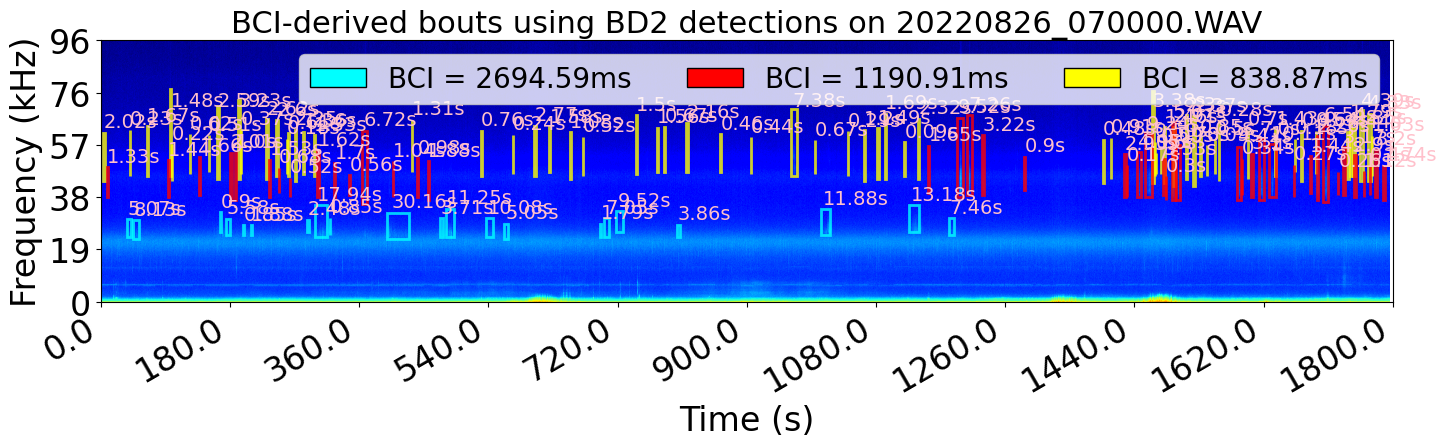

In [12]:
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt.get_bout_params_from_location(actvt.assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [13]:
filepath_key = EXAMPLE_FILES_from_LOCATIONS[bout_params['site_key']][5]
filename = filepath_key.split('/')[-1]

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1440
duration = 180
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

data_params = dict()
data_params['site_tag'] = bout_params['site_key']
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 4096
spec_features['cmap'] = 'jet'

In [14]:
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt.get_bout_params_from_location(assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

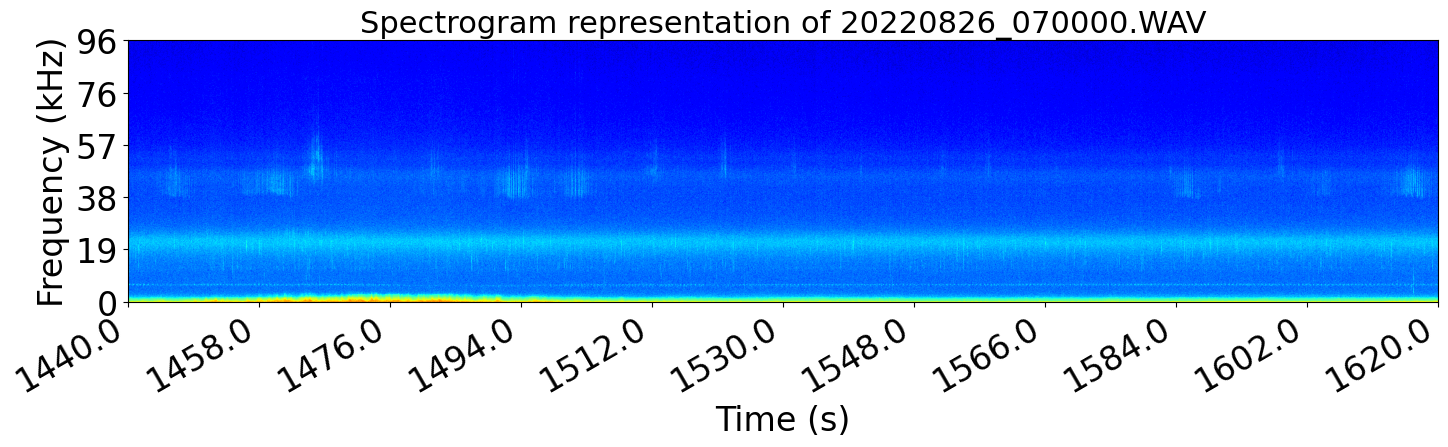

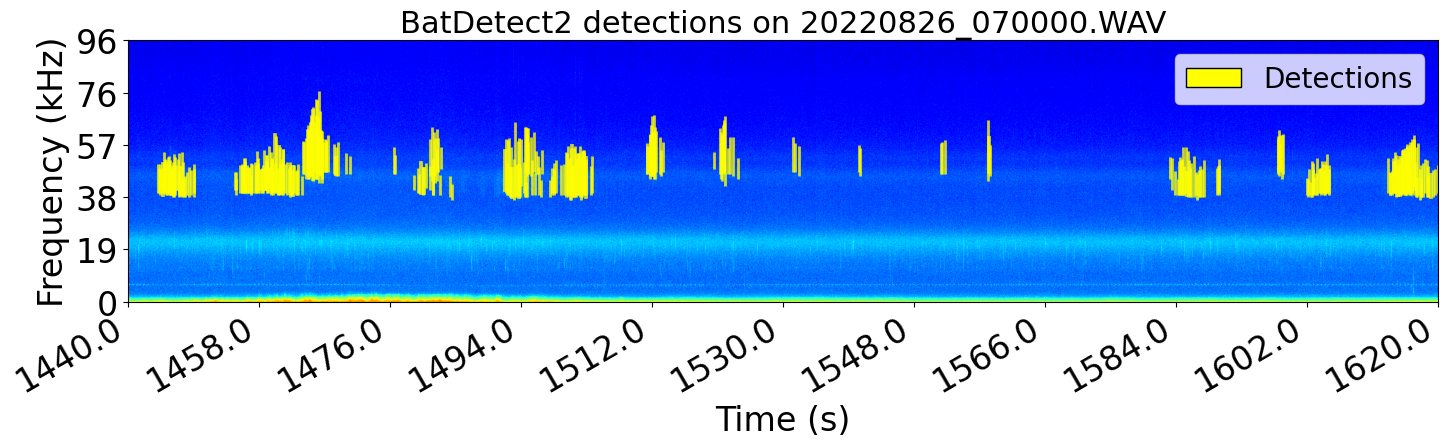

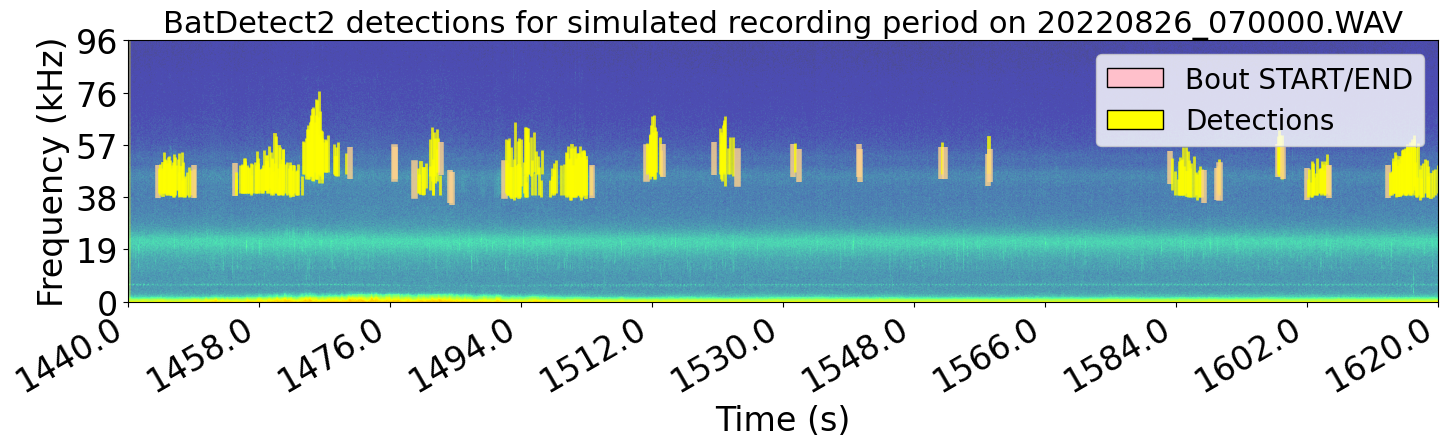

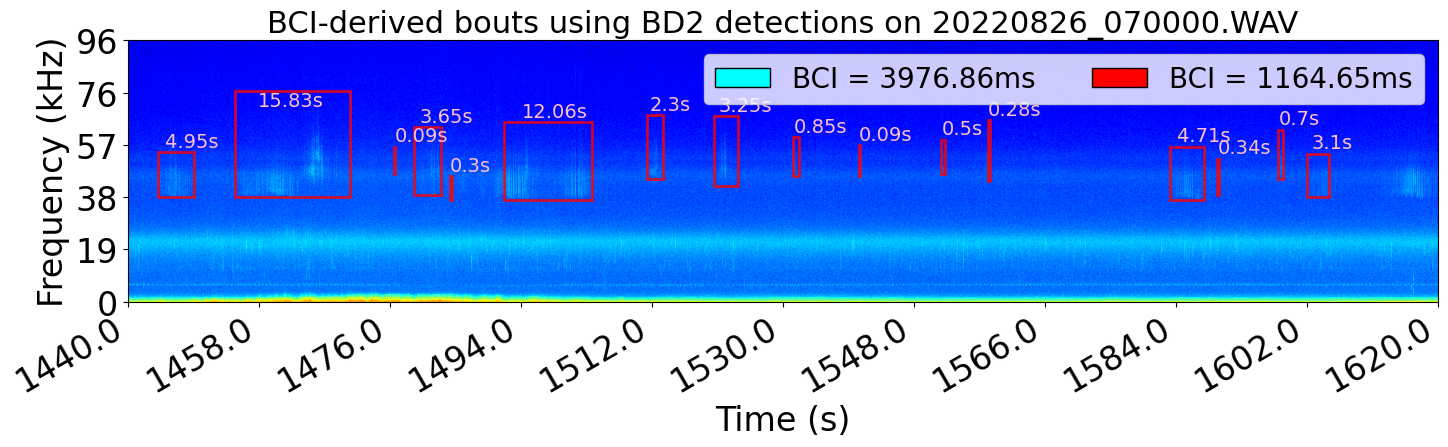

In [15]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

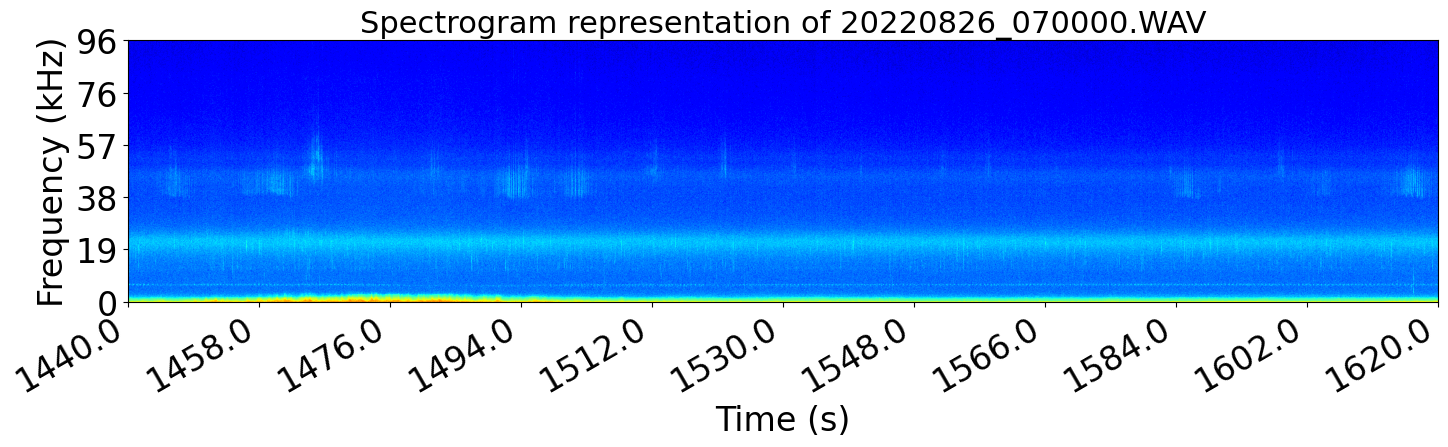

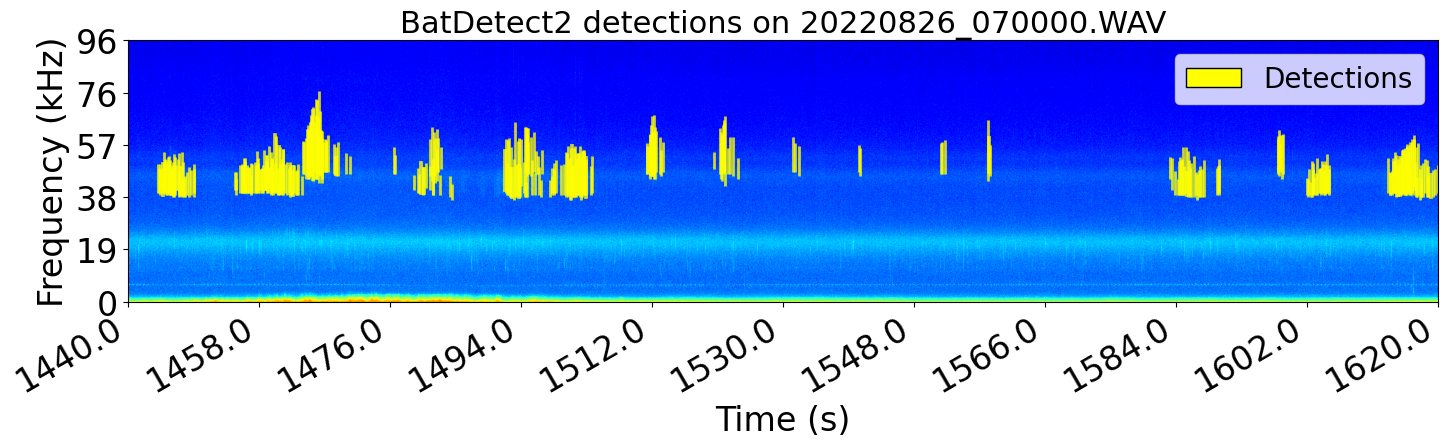

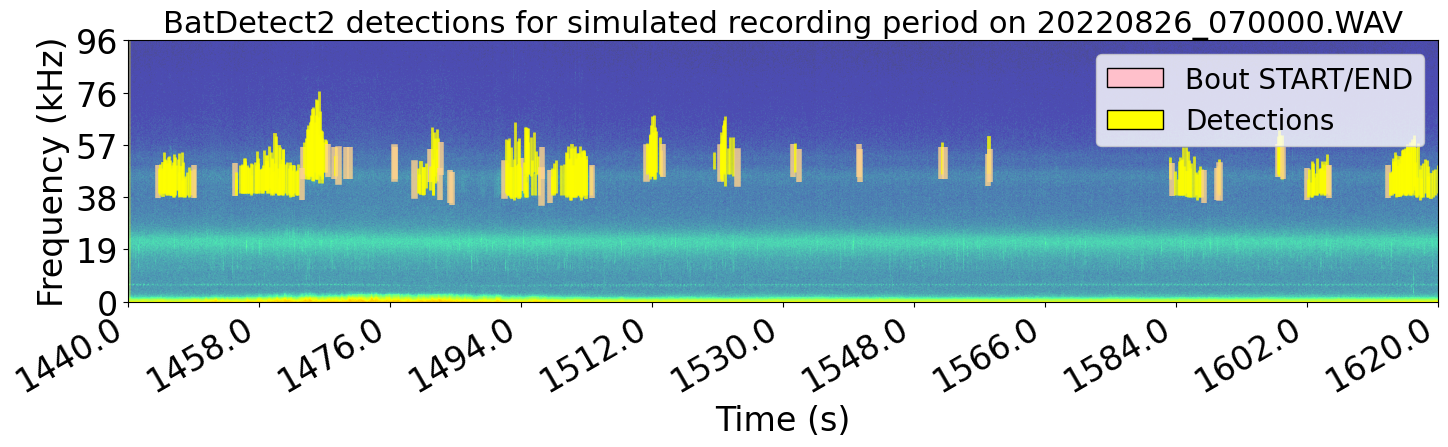

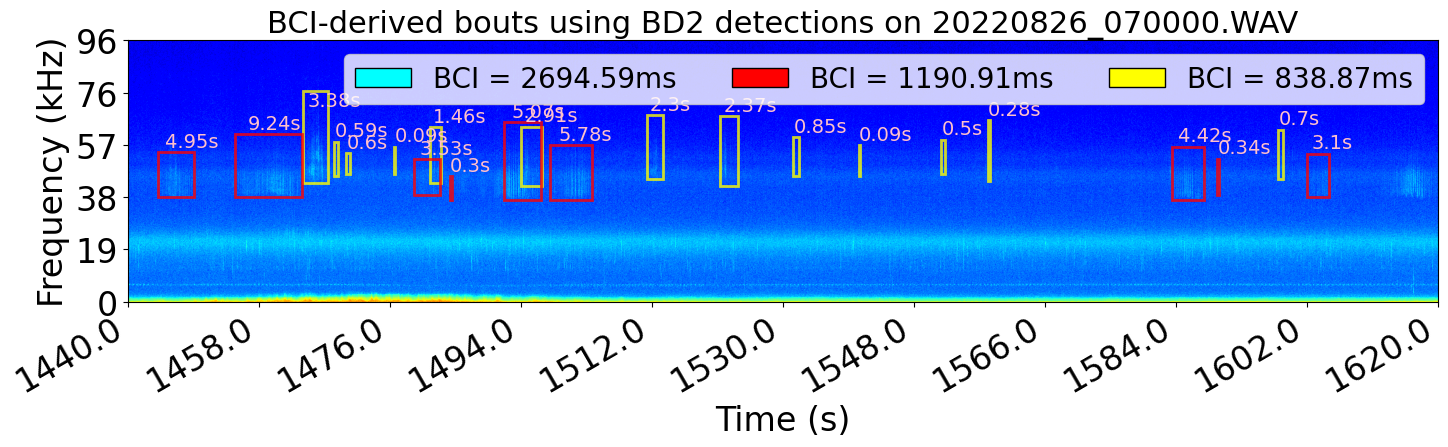

In [16]:
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt.get_bout_params_from_location(actvt.assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [19]:
filepath_key = EXAMPLE_FILES_from_LOCATIONS[bout_params['site_key']][5]
filename = filepath_key.split('/')[-1]

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 240
duration = 180
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB

data_params = dict()
data_params['site_tag'] = bout_params['site_key']
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

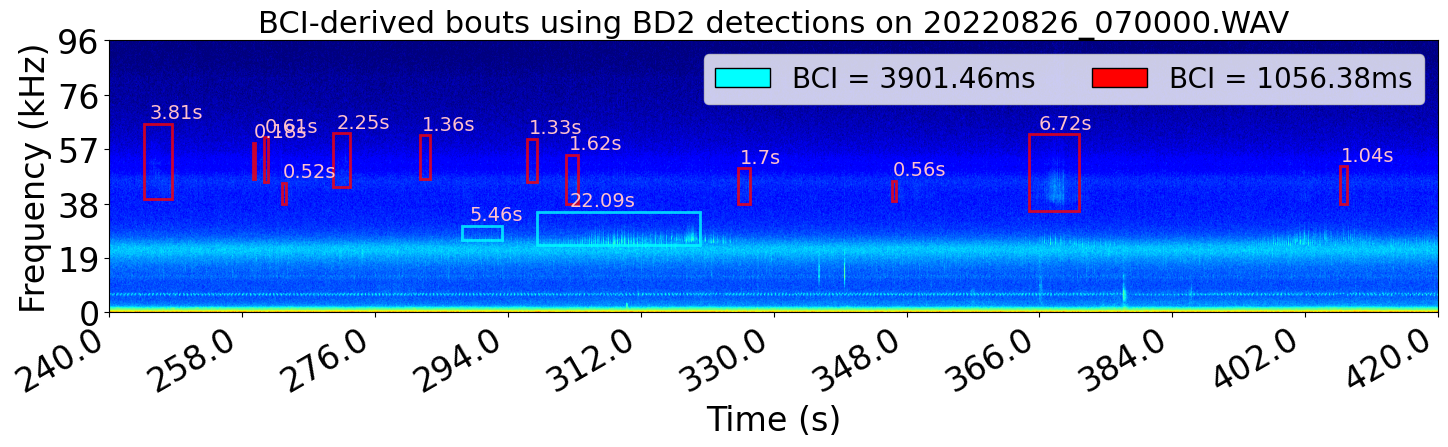

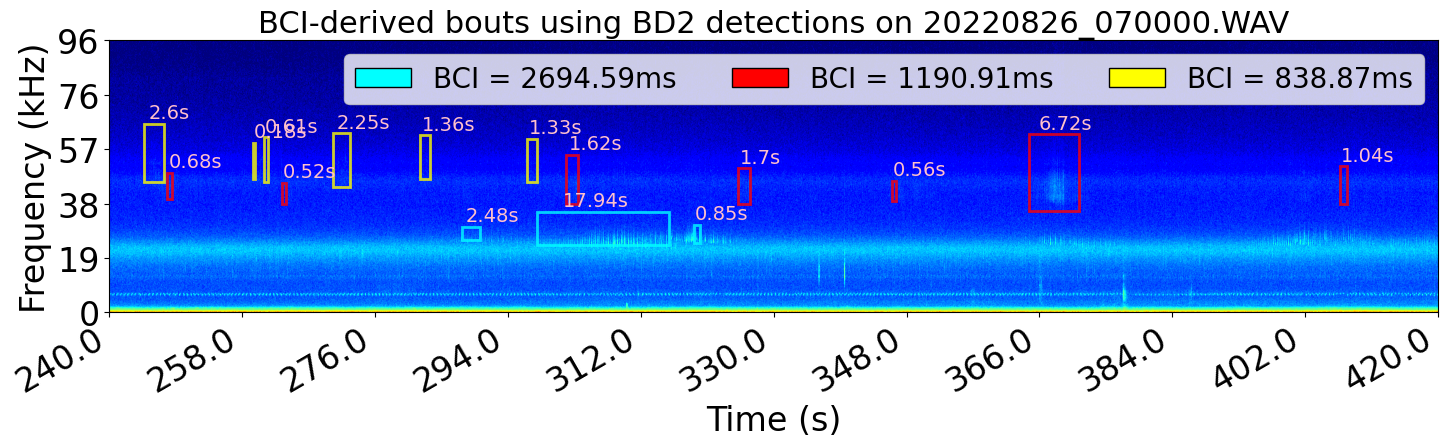

In [24]:
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt.get_bout_params_from_location(assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]
plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt.get_bout_params_from_location(actvt.assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)